## Principal compolent analysis

### Introduction

PCA is a technique for dimensionality reduction. It is used to reduce the number of features in a dataset while retaining the most important information. 

#### Read the data


In [1]:
# read the data from the given file.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_data(filename):
    df = pd.read_csv(filename, sep=',', header=None)
    return df

input_file = 'data/6D_data_points.txt'

df = read_data(input_file)

/home/akib/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


#### Print some properties of the data

In [2]:
print(df.shape)
print(df.dtypes)
print(df.head())

(2203, 6)
0    float64
1    float64
2    float64
3    float64
4    float64
5    float64
dtype: object
         0       1       2       3        4       5
0  -8.9838 -8.8101 -8.7325  6.8276   8.0838 -3.6102
1  -9.0780 -8.9883 -9.1242  7.0751   8.1816 -4.0691
2   7.1802 -5.1141 -8.4475 -0.7136   1.3681 -1.5898
3  10.6290 -9.0872  2.9779  6.4922  10.2654  7.7818
4  -9.0626 -8.9339 -9.0517  6.9821   8.3278 -4.0025


### Implement PCA

Steps:
1. Normalize the data
1. Compute the covariance matrix
1. Compute the eigenvalues and eigenvectors of the covariance matrix
1. Sort the eigenvalues and eigenvectors
1. Select the first k eigenvectors
1. Transform the original data

In [3]:
def PCA(X, reduced_dim):
    # mean center the data
    X = X - np.mean(X, axis=0)
    # calculate the covariance matrix
    cov_mat = np.cov(X, rowvar=False)
    # calculate eigenvalues and eigenvectors of the covariance matrix
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)
    # sort the eigenvalues in descending order
    sorted_index = np.argsort(eigen_values)[::-1]
    # sort the eigenvectors according to the sorted eigenvalues
    eigen_vectors = eigen_vectors[:, sorted_index]
    # select the first n eigenvectors, n is desired dimension
    eigen_vectors = eigen_vectors[:, 0:reduced_dim]
    # transform the data
    X = np.dot(X, eigen_vectors)
    return X

def PCA_sklearn(X, reduced_dim):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=reduced_dim)
    X_reduced = pca.fit_transform(X)
    return X_reduced

(2203, 2)


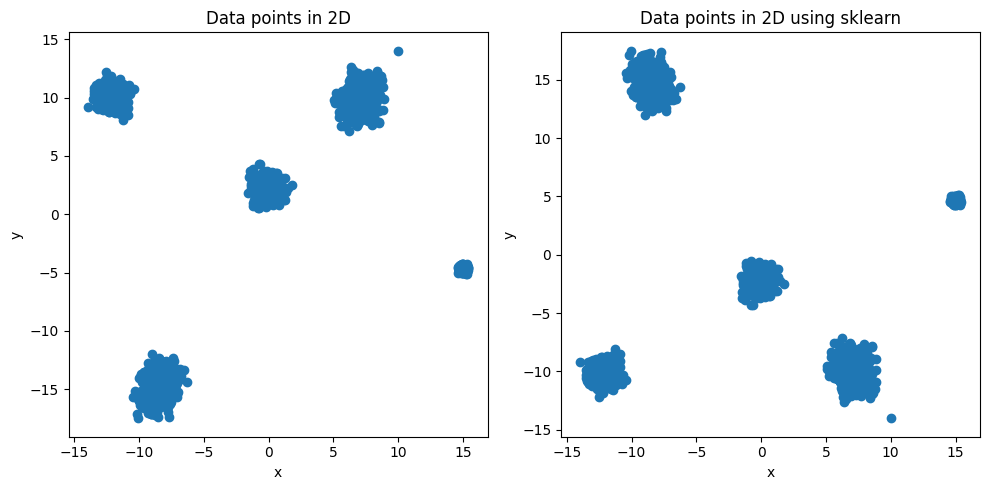

In [4]:
X = df.values
X_reduced = PCA(X, 2)
X_reduced_sklearn = PCA_sklearn(X, 2)

# print the shape of the reduced data
print(X_reduced.shape)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the reduced data
axs[0].scatter(X_reduced[:, 0], X_reduced[:, 1])
axs[0].set_title('Data points in 2D')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Plot the reduced data using sklearn
axs[1].scatter(X_reduced_sklearn[:, 0], X_reduced_sklearn[:, 1])
axs[1].set_title('Data points in 2D using sklearn')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

# Display the figure with subplots
plt.tight_layout()
plt.show()

## Gaussian Mixture Models

### Introduction

Gaussian Mixture Models (GMMs) are a probabilistic model for representing normally distributed subpopulations within an overall population.

In this exercise, we will use GMMs to perform clustering.

In [5]:
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, k, max_iter=5, verbose=False):
        self.k = k
        self.max_iter = int(max_iter)
        self.verbose = verbose

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) + np.eye(self.m) * 1e-6 for _ in range(self.k) ]

    def e_step(self, X):
        # E-Step: update weights and phi holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(), 
                bias=True)
            # add a small variance to avoid numerical instability
            self.sigma[i] += np.eye(self.m) * 1e-6

    def fit(self, X):
        self.initialize(X)
        
        old_log_likelihood = 0
        self.log_likelihoods = []  # Store log-likelihoods for each iteration
        self.mus = []  # Store mus for each iteration
        self.sigmas = []  # Store sigmas for each iteration
        
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            
            # Store the intermediate results
            self.log_likelihoods.append(np.sum(np.log(np.sum(self.weights, axis=1))))
            self.mus.append(self.mu.copy())
            self.sigmas.append(self.sigma.copy())
            
            # Calculate the log-likelihood
            new_log_likelihood = self.log_likelihoods[-1]
            
            # Check for convergence
            if np.abs(new_log_likelihood - old_log_likelihood) < 1e-20:
                if self.verbose:
                    print(f'Converged after {iteration} iterations.')
                break
            
            old_log_likelihood = new_log_likelihood
            
    def log_likelihood(self, X):
        # return log-likelihood of the model
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        log_likelihood = np.log(np.sum(likelihood, axis=1))
        return np.sum(log_likelihood)
            
    def predict_proba(self, X):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

In [6]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None,num_ellipse=4, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    # Draw the Ellipse
    for nsig in range(1, num_ellipse + 1):
        ax.add_patch(Ellipse(xy=position, width=nsig * width, height=nsig * height, angle=angle, fill=False, **kwargs))


In [7]:
from matplotlib import animation

def generate_plots(gmm, X, K):
    fig, ax = plt.subplots()
    
    def update(i):
        ax.clear()
        ax.scatter(X[:, 0], X[:, 1], c=gmm.predict(X))
        for j in range(K):
            draw_ellipse(gmm.mus[i][j], gmm.sigmas[i][j], alpha=0.5)
        ax.set_title(f'Iteration {i+1}')
    
    ani = animation.FuncAnimation(fig, update, frames=len(gmm.log_likelihoods), repeat=True)
    
    return ani

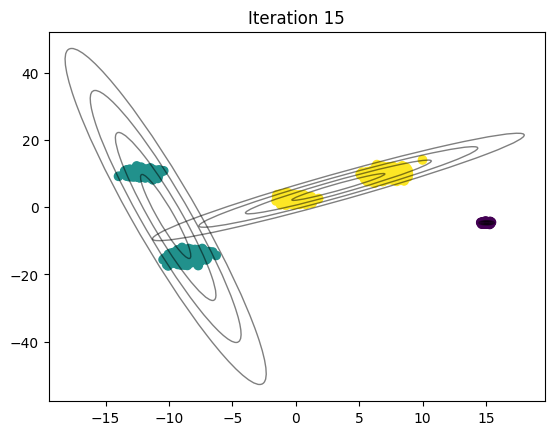

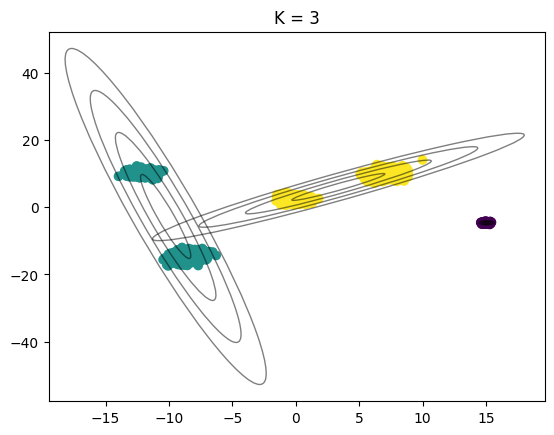

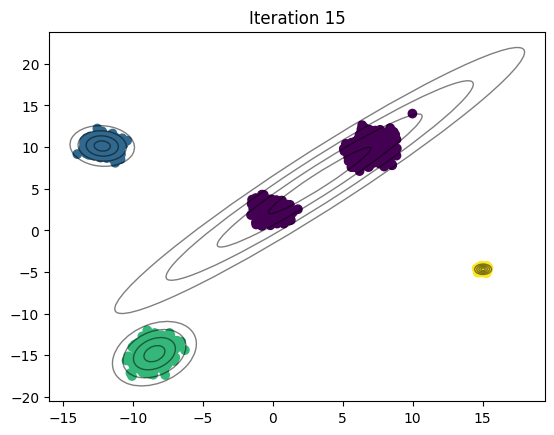

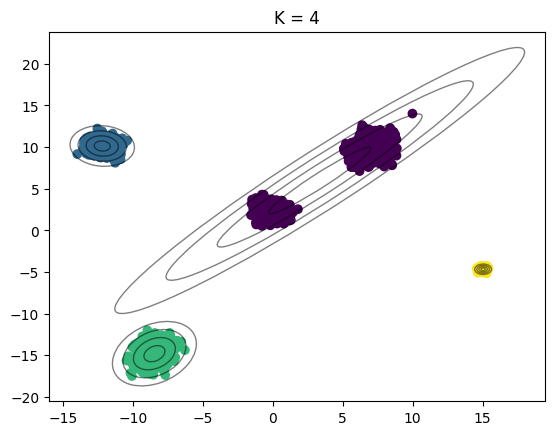

In [8]:

# Define the range for K
K_range = range(3, 9)

# Initialize the list to store the best log-likelihoods
best_log_likelihoods = []


# For each value of K
for K in K_range:
    best_log_likelihood = float('-inf')
    best_gmm = None
    
    # Run the EM algorithm five times
    for _ in range(5):
        gmm = GMM(K, max_iter=100, verbose=False)
        gmm.fit(X_reduced)
        
        # Compute the log-likelihood
        epsilon = 1e-15
        log_likelihood = gmm.log_likelihood(X_reduced)
        
        # Update the best log-likelihood if necessary
        if log_likelihood > best_log_likelihood:
            best_log_likelihood = log_likelihood
            best_gmm = gmm
    
    # Store the best log-likelihood for this value of K
    best_log_likelihoods.append(best_log_likelihood)
    
    anim = generate_plots(gmm=best_gmm, X=X_reduced, K=K)
    gif_filename = f'gmm_k_{K}.gif'
    anim.save(gif_filename, writer='imagemagick', fps=5)
    # show the plot for this k
    plt.figure()
    # add a scatter plot of the data points
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=best_gmm.predict(X_reduced))
    # add the ellipses
    for i in range(K):
        draw_ellipse(best_gmm.mu[i], best_gmm.sigma[i], alpha=0.5)
    # add a title        
    plt.title(f'K = {K}')
    plt.show()

    

# Plot the best log-likelihoods
plt.plot(K_range, best_log_likelihoods)
plt.title('Best Log-Likelihood vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Best Log-Likelihood')
plt.show()